events      WARNING 	Correcting user input 'US' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.7.0]
INFO:fastf1.fastf1.core:Loading data for United States Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for 

,X,Y,Number,Letter,Angle,Distance
10,15557.826820,6316.789651,11,,32.935578,2526.988865
11,4025.114839,3996.419189,12,,-215.093808,3734.639666
12,4941.583384,2058.167091,13,,-35.266441,3977.357954


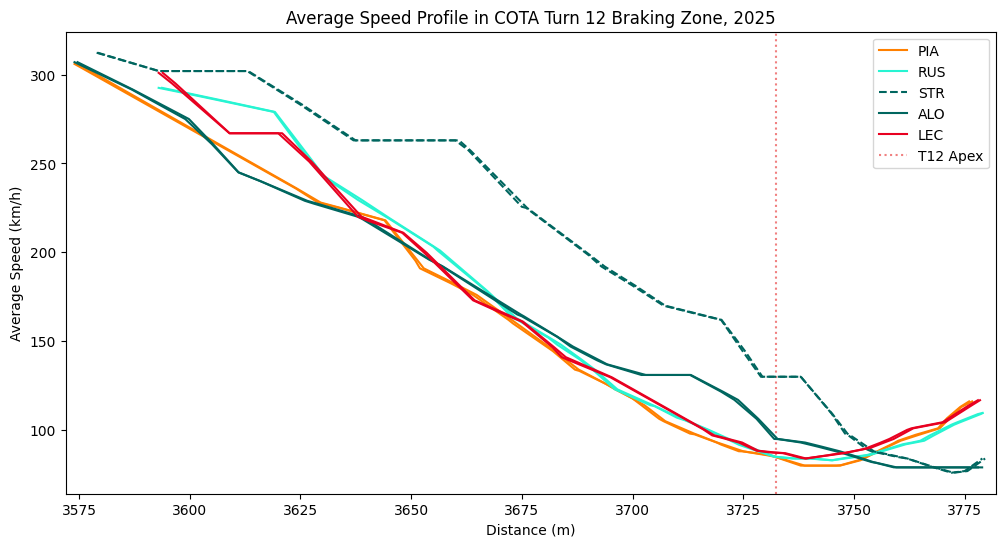

In [9]:
#install and import necessary packages
!pip install fastf1
import fastf1
from fastf1.plotting import get_driver_color
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#filter valid laps
session=fastf1.get_session(2025, 'US', 'R')
session.load(laps=True, telemetry=True, weather=False, messages=False)
laps=session.laps
valid_laps=laps.pick_accurate().pick_wo_box()
valid_laps=valid_laps[valid_laps['LapTime'].notna() & (valid_laps['TrackStatus']=='1')]
valid_laps=valid_laps[valid_laps['Deleted'].isnull()]

#determine the start and end of turn 12 braking zone
#estimate the braking zone to start from 160m before apex and end at 50m after apex
circuit_info=session.get_circuit_info()
corners=circuit_info.corners
t12=corners[corners['Number'].isin([11,12,13])]
display(t12)
t12_start=3732-160
t12_end=3732+50

#group speed with the interval width of 1.0
def average_speed_profile(
    session,
    driver,
    start_dist,
    end_dist,
    bin_size=1.0
):

    #collect telemetry for valid laps
    drv_laps=valid_laps.pick_drivers(driver)
    tel = (
        drv_laps
        .get_telemetry()
        .add_distance()
    )

    tel = tel[
        (tel['Distance'] >= start_dist) &
        (tel['Distance'] <= end_dist)
    ][['Distance', 'Speed']]

    tel['DistBin'] = (
        np.floor((tel['Distance'] - start_dist) / bin_size)
        * bin_size
        + start_dist
    )

    #return average speed per distance bin
    avg_profile = (
        tel
        .groupby('DistBin', as_index=False)
        .mean()
        .rename(columns={'DistBin': 'Distance'})
    )

    return avg_profile
#plot and format
fig, ax = plt.subplots(figsize=(12, 6))

for drv in ['PIA', 'RUS', 'STR', 'ALO', 'LEC']:
    avg = average_speed_profile(
        session,
        drv,
        t12_start,
        t12_end
    )

    linestyle = '--' if drv == 'STR' else '-'

    ax.plot(
        avg['Distance'],
        avg['Speed'],
        label=drv,
        linestyle=linestyle,
        color=get_driver_color(drv, session)
    )
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Average Speed (km/h)')
ax.set_title('Average Speed Profile in COTA Turn 12 Braking Zone, 2025')
ax.set_xlim([t12_start, t12_end])
ax.axvline(x=3732.43, color='lightcoral', linestyle=':', label='T12 Apex', zorder=1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()